In [88]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, pickle
import sys
from skimage import io
import os

# sys.path.append("../../bioseg")

sys.path.append("../../")


%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Dataset 

In [90]:
data_dir = '/data/natalia/intern20/PaperData/MIBI_2channel/' ## This should be the file where the .npz files are

pd_file = pd.read_csv(data_dir+'files.csv',index_col=0)
pd_file['input_dir'] = data_dir
pd_file.to_csv(data_dir + 'files.csv')

print(pd_file) 
print()

#get number of instances per segmentation class
for i in range(len(pd_file)):
    group = pd_file['group'][i]
    print(pd_file['input_dir'][i] + pd_file['input_file'][i])
    npz_read = np.load(pd_file['input_dir'][i] + pd_file['input_file'][i])
    image = npz_read['image']        
    label = npz_read['label']
    
    #initialize lists
    if i == 0:
        nclasses = label.shape[-1]
        nlabels_class_train_list = [0 for i in range(nclasses)]
        nlabels_class_test_list = [0 for i in range(nclasses)]
        
    for ix in range(label.shape[-1]):
        if group == 'train':
            nlabels_class_train_list[ix] += np.unique(label[...,ix]).shape[0] - 1
        else:
            nlabels_class_test_list[ix] += np.unique(label[...,ix]).shape[0] - 1

print()
print('----')
print('total train instances per class (',nclasses, 'classes)')
print(nlabels_class_train_list)
print('total test instances per class (',nclasses, 'classes)')
print(nlabels_class_test_list)

   prefix                                        input_dir  input_file  group
0  image0  /data/natalia/intern20/PaperData/MIBI_2channel/  image0.npz  train
1  image1  /data/natalia/intern20/PaperData/MIBI_2channel/  image1.npz  train
2  image2  /data/natalia/intern20/PaperData/MIBI_2channel/  image2.npz   test
3  image3  /data/natalia/intern20/PaperData/MIBI_2channel/  image3.npz  train

/data/natalia/intern20/PaperData/MIBI_2channel/image0.npz
/data/natalia/intern20/PaperData/MIBI_2channel/image1.npz
/data/natalia/intern20/PaperData/MIBI_2channel/image2.npz
/data/natalia/intern20/PaperData/MIBI_2channel/image3.npz

----
total train instances per class ( 3 classes)
[294, 260, 191]
total test instances per class ( 3 classes)
[49, 44, 58]


## Scribbles generation

In [51]:
nbudget = 150 ## number of label's scribbles
print((nbudget*np.array(nlabels_class_train_list)/np.sum(nlabels_class_train_list)).astype('int'))


if nbudget == 150:
    nlabels_objecttype = [60,50,40] #cytoplasm, nuclei in cytoplasm, nuclei out of cytoplasm
    

nlabels_budget = np.sum(nlabels_objecttype)
print('total budget : ', nlabels_budget)

[59 52 38]
total budget :  150


/data/natalia/intern20/PaperData/MIBI_2channel/image0.npz


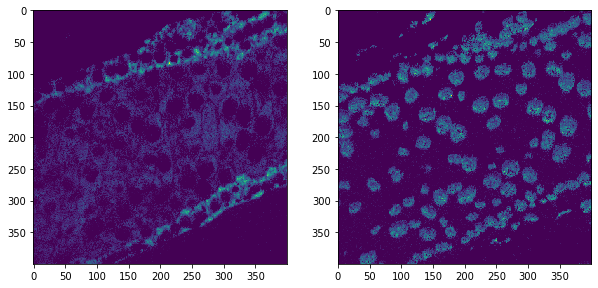

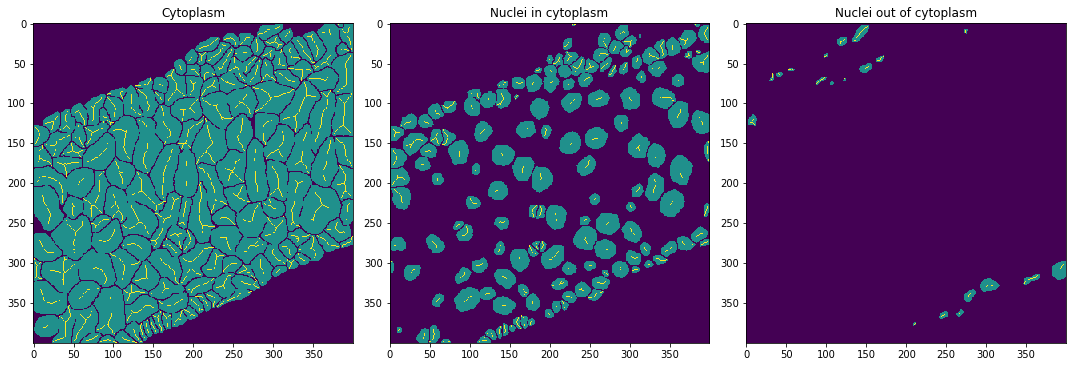

/data/natalia/intern20/PaperData/MIBI_2channel/image1.npz


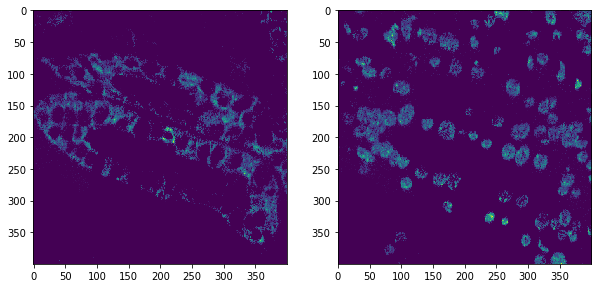

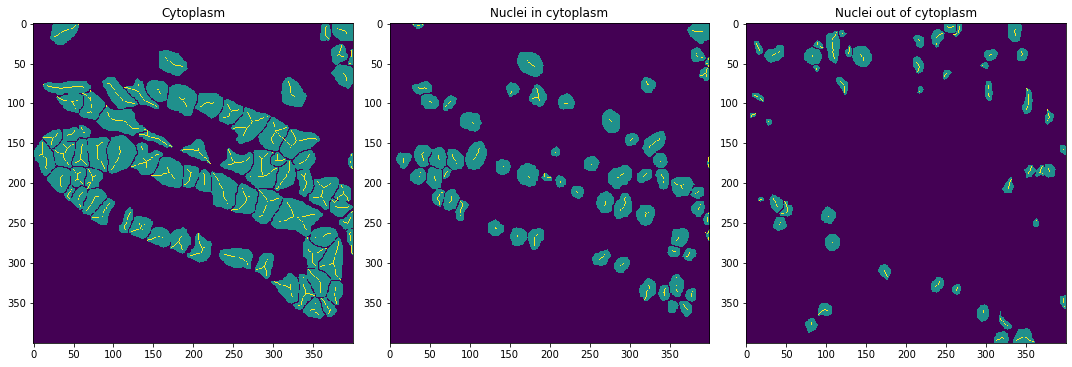

/data/natalia/intern20/PaperData/MIBI_2channel/image3.npz


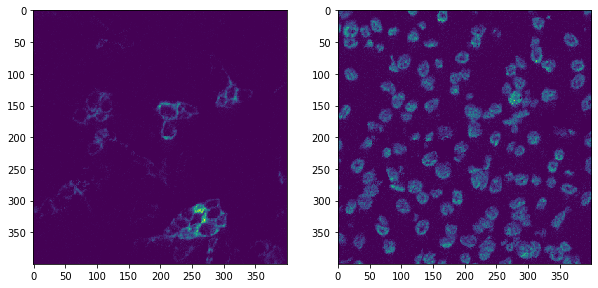

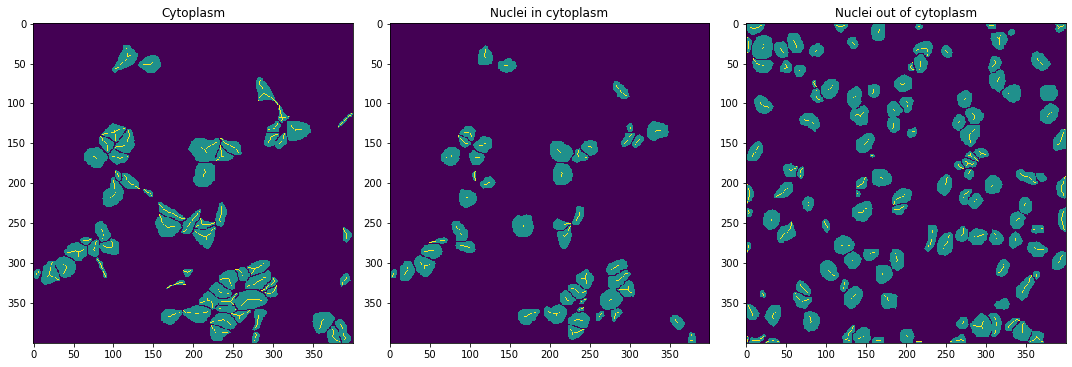

In [61]:
from skimage import morphology
from dataprocessing.labelgeneration import get_scribbles

#load train segmentations in a list
X_train_list = []

Y_gt_train_ch0_list = []
Y_gt_train_ch1_list = []
Y_gt_train_ch2_list = []

files_train_list_aux = []

nlabels_total0 = 0
nlabels_total1 = 0
nlabels_total2 = 0

for i in range(len(pd_file)):
    group = pd_file['group'][i]
    if group == 'train':

        print(pd_file['input_dir'][i] + pd_file['input_file'][i])
        npz_read = np.load(pd_file['input_dir'][i] + pd_file['input_file'][i])
        image = npz_read['image']        
        label0 = npz_read['label'][...,0]
        label1 = npz_read['label'][...,1]
        label2 = npz_read['label'][...,2]
        
        nlabels_total0 += np.unique(label0).shape[0]-1
        nlabels_total1 += np.unique(label1).shape[0]-1
        nlabels_total2 += np.unique(label2).shape[0]-1
        
        X_train_list.append(image)
        Y_gt_train_ch0_list.append(label0)
        Y_gt_train_ch1_list.append(label1)
        Y_gt_train_ch2_list.append(label2)
        
        files_train_list_aux.append([pd_file['input_dir'][i],
                                 pd_file['input_file'][i],
                                 pd_file['prefix'][i],])

        #nuclei mask
        nuclei0 = np.zeros_like(label0)
        nuclei0[label0>0] = 1
        
        nuclei1 = np.zeros_like(label1)
        nuclei1[label1>0] = 1
        
        nuclei2 = np.zeros_like(label2)
        nuclei2[label2>0] = 1

        plt.figure(figsize=(10,5))
        
        plt.subplot(1,2,1)
        plt.imshow(image[...,0])
        
        plt.subplot(1,2,2)
        plt.imshow(image[...,1])
        
        plt.figure(figsize=(15,5))
        plt.subplot(1,3,1)
        skeleton = morphology.skeletonize(nuclei0)
        plt.title('Cytoplasm')
        plt.imshow(nuclei0+skeleton)

        plt.subplot(1,3,2)
        skeleton = morphology.skeletonize(nuclei1)
        plt.title('Nuclei in cytoplasm')
        plt.imshow(nuclei1+skeleton)
        
        plt.subplot(1,3,3)
        skeleton = morphology.skeletonize(nuclei2)
        plt.title('Nuclei out of cytoplasm')
        plt.imshow(nuclei2+skeleton)
        
        plt.tight_layout()
#         plt.axes(off)
        plt.show()

In [67]:
np.random.seed(43)

### Cytoplasm scribbles (ch0)
Y_out_ch0_list, nscribbles_ch0_list, nlabels_ch0_list = get_scribbles(Y_gt_train_ch0_list,
                                                                     nlabels_objecttype[0],
                                                                     fov_box=(32,32),
                                                                     radius_pointer=0,
                                                                     disk_scribble = True,
                                                                     sample_back = True)

### Nuclei in cytoplasm scribbles (ch1)
Y_out_ch1_list, nscribbles_ch1_list, nlabels_ch1_list = get_scribbles(Y_gt_train_ch1_list,
                                                                     nlabels_objecttype[1],
                                                                     fov_box=(32,32),
                                                                     radius_pointer=0,
                                                                     disk_scribble = False,
                                                                     sample_back = False)
nlabels_total_budget = nlabels_budget + 0
nlabels_total_budget -= (np.sum(nscribbles_ch1_list) + np.sum(nscribbles_ch0_list))

### Nuclei out of cytoplasm scribbles (ch2)
Y_out_ch2_list, nscribbles_ch2_list, nlabels_ch2_list = get_scribbles(Y_gt_train_ch2_list,
                                                                     nlabels_total_budget,
                                                                     fov_box=(32,32),
                                                                     radius_pointer=0,
                                                                     disk_scribble = False,
                                                                     sample_back = False)

for i in range(len(Y_out_ch1_list)):
    
    #nuclei out of cytoplasm is exclusive with cytoplasm regions then:
    aux = Y_out_ch0_list[i][:,:,1] + 0
    aux[ Y_out_ch2_list[i][:,:,0]>0] = 1
    Y_out_ch0_list[i][:,:,1] = aux

    #nuclei out of cytoplasm is exclusive with nuclei in citoplasm then:
    aux = Y_out_ch1_list[i][:,:,1] + 0
    aux[ Y_out_ch2_list[i][:,:,0]>0] = 1
    Y_out_ch1_list[i][:,:,1] = aux

total labels per sample (image):  [160.  72.  62.]
sample_i,nbudget,nscribbles
2 60 20
1 38 19
0 18 18
total labels per sample (image):  [152.  61.  47.]
sample_i,nbudget,nscribbles
2 50 16
1 34 17
0 16 16
total labels per sample (image):  [ 20.  49. 122.]
sample_i,nbudget,nscribbles
0 35 11
1 23 11
2 12 12


0 ['/data/natalia/intern20/PaperData/MIBI_2channel/', 'image0.npz', 'image0']
image0_2tasks1x2classes_3images_scribble_n150.npz
check unique values scribbles : [0. 1.]


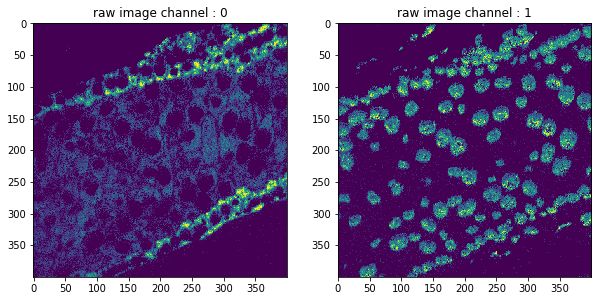

 task 0 ; classes : [0]
check sum of scribbles on same class (=1 or 0) : [0. 1.]


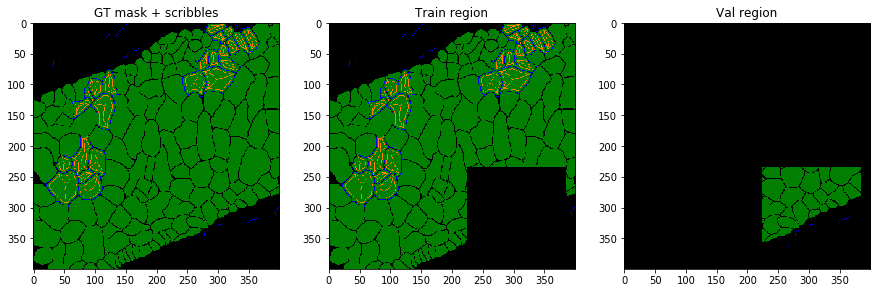

 task 1 ; classes : [1, 2]
check sum of scribbles on same class (=1 or 0) : [0. 1.]


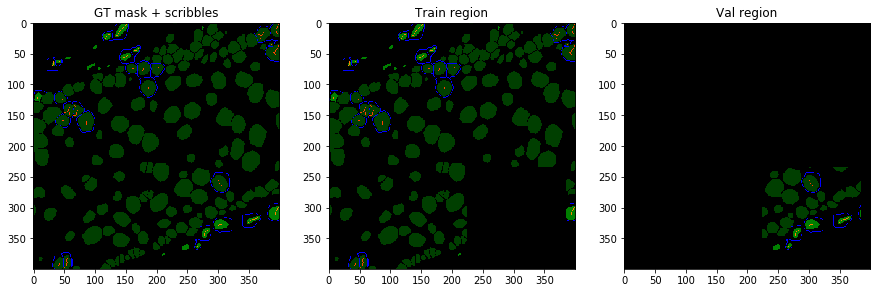

1 ['/data/natalia/intern20/PaperData/MIBI_2channel/', 'image1.npz', 'image1']
image1_2tasks1x2classes_3images_scribble_n150.npz
check unique values scribbles : [0. 1.]


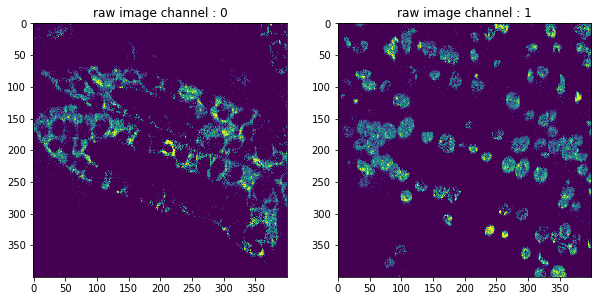

 task 0 ; classes : [0]
check sum of scribbles on same class (=1 or 0) : [0. 1.]


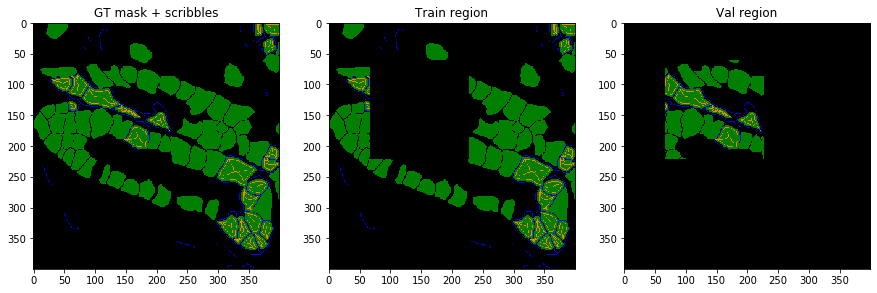

 task 1 ; classes : [1, 2]
check sum of scribbles on same class (=1 or 0) : [0. 1.]


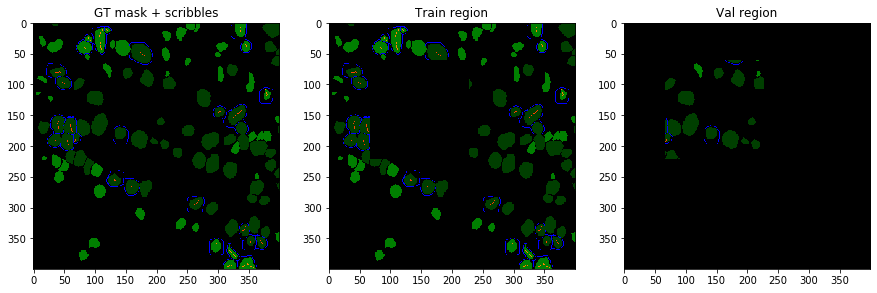

2 ['/data/natalia/intern20/PaperData/MIBI_2channel/', 'image3.npz', 'image3']
image3_2tasks1x2classes_3images_scribble_n150.npz
check unique values scribbles : [0. 1.]


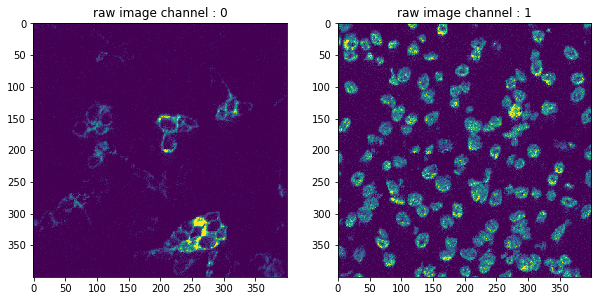

 task 0 ; classes : [0]
check sum of scribbles on same class (=1 or 0) : [0. 1.]


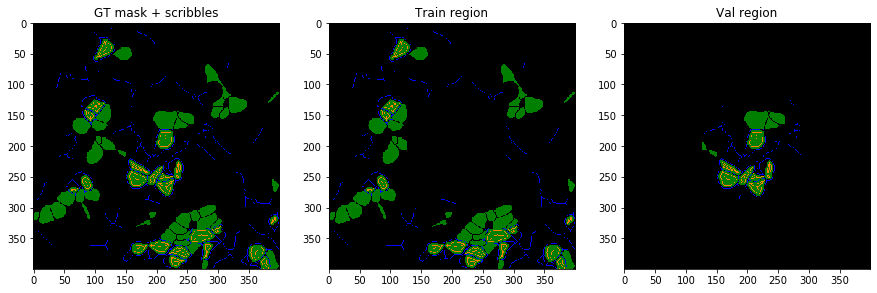

 task 1 ; classes : [1, 2]
check sum of scribbles on same class (=1 or 0) : [0. 1.]


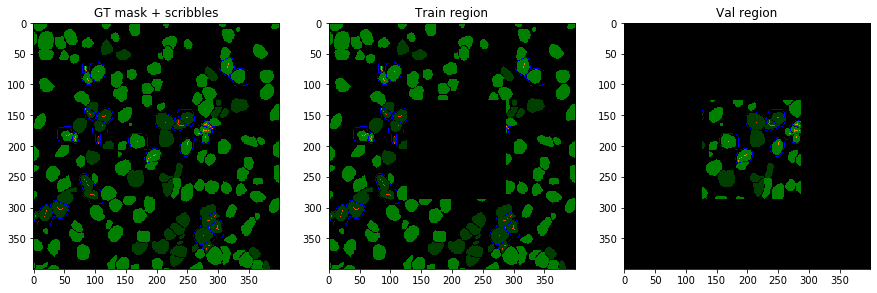

In [80]:
## Save scribbles
val_perc = 0.4
import copy
from csbdeep.utils import normalize
np.random.seed(9)
np.random.seed(44)
files_train_list = copy.deepcopy(files_train_list_aux)
for i in range(len(files_train_list)):
    
    image = X_train_list[i]
    label_gt = np.concatenate([Y_gt_train_ch0_list[i][...,np.newaxis],
                                Y_gt_train_ch1_list[i][...,np.newaxis],
                                Y_gt_train_ch2_list[i][...,np.newaxis]],axis=-1)
    scribbles_ch = [Y_out_ch0_list[i],Y_out_ch1_list[i],Y_out_ch2_list[i]]
    
    
    ### save scribbles file name
    print(i,files_train_list[i])
    name_save = files_train_list[i][1].split('.')[0] + '_2tasks1x2classes_3images_scribble_n'+str(int(nlabels_budget))+'.npz'
    print(name_save)
    files_train_list[i].extend([name_save])
    
    ### save number of labels with scribbles per channel
    for ch in np.arange(len(scribbles_ch)):
        label_ch = label_gt[...,ch]
        s_ch = scribbles_ch[ch]

        #nlabels with scribbles
        label_wscribble = np.unique(label_ch[s_ch[...,0]>0].flatten())
        nscribbles = label_wscribble.shape[0]
        nlabels = np.unique(label_ch[label_ch>0]).shape[0]
        pixels_scribbled_TP = np.round(100*np.sum(s_ch[...,0]>0)/ (np.sum(label_ch>0)),2)
        pixels_scribbled_TN = np.round(100*np.sum(s_ch[...,1]>0)/ (np.sum(label_ch==0)),2)
        files_train_list[i].extend([int(nlabels),int(nscribbles),
                                    label_wscribble,pixels_scribbled_TP,pixels_scribbled_TN])
    
    ### Define classification tasks and their scribbles
    tasks_classes = {'0':[0],'1':[1,2]}
#     tasks_classes = {'0':[0],'1':[1],'2':[2]}
    
    scribble = None
    for tasks in tasks_classes.keys():
        start_task = True
        for ch in tasks_classes[tasks]:
            
            s_ch = scribbles_ch[ch]
            
            label_ch = np.array(label_gt)
            label_ch[...,ch] = 0
            label_ch = label_ch[...,tasks_classes[tasks]]
            label_ch[label_ch>0] = 1
            label_ch = np.sum(label_ch,-1)
            
            if start_task:
                background = np.array(s_ch[...,1])*(1-label_ch) + 0 #make sure no foreground is set as background
                scribble_task = np.array(s_ch[...,0])[...,np.newaxis] + 0
                start_task = False
            else:
                background += np.array(s_ch[...,1])*(1-label_ch) #make sure no foreground is set as background
                scribble_task = np.concatenate([scribble_task, np.array(s_ch[...,0])[...,np.newaxis]],axis = -1)
                
        scribble_task = np.concatenate([scribble_task,background[...,np.newaxis]],axis = -1)
        scribble_task[scribble_task>0] = 1
        
        if scribble is None:
            scribble = np.array(scribble_task)
        else:
            scribble = np.concatenate([scribble,scribble_task],axis = -1)
                
    
    ### validation sample region mask ###
    region_val_size = [int(image.shape[0] * val_perc/2),int(image.shape[1] * val_perc/2)] #validation region
    mask_scribbles = np.sum(scribble,axis = -1)
    mask_scribbles[mask_scribbles>0] = 1
    from scipy import ndimage
    mask_scribbles = ndimage.convolve(mask_scribbles, np.ones([5,5]), mode='constant', cval=0.0)
    #remove borders
    mask_scribbles[-region_val_size[0]:,:] = 0
    mask_scribbles[:,-region_val_size[1]:] = 0
    mask_scribbles[0:region_val_size[0],:] = 0
    mask_scribbles[:,0:region_val_size[1]] = 0
    val_center = np.random.multinomial(1, mask_scribbles.flatten()/np.sum(mask_scribbles.flatten()), size=1).flatten()
    ix_center = np.argmax(val_center)
    ix_row = int(np.floor(ix_center/image.shape[1]))
    ix_col = int(ix_center - ix_row * image.shape[1])
    validation_mask = np.zeros([image.shape[0],image.shape[1]])
    validation_mask[ix_row-region_val_size[0]:ix_row+region_val_size[0],
                    ix_col-region_val_size[1]:ix_col+region_val_size[1]] = 1
    
    ## saving
    print('check unique values scribbles :',np.unique(scribble))
    np.savez(files_train_list[i][0]+name_save,scribble=scribble,val_mask = validation_mask)
    
    ############################################# Plots #############################################
    #plot input channels
    plt.figure(figsize=(10,5))
    ix = 0
    for ch in range(image.shape[-1]):
        image_plot = normalize(image[...,ch],pmin=1,pmax=99.8,clip = True)
        plt.subplot(1,image.shape[-1],ix + 1)
        ix += 1
        plt.title('raw image channel : '+ str(ch))
        plt.imshow(image_plot)
    plt.show()
    
    itask = 0
    for tasks in tasks_classes.keys():
        classes_lists = tasks_classes[tasks]
        print(' task '+ str(tasks) + ' ; classes :',classes_lists)
        
        label_ch = np.array(label_gt[...,classes_lists])
        label_ch[label_ch>0] = 1
        label_ch = np.sum(label_ch*(np.arange(len(classes_lists))+1)[np.newaxis,np.newaxis,:],-1)
        print('check sum of scribbles on same class (=1 or 0) :',
              np.unique(np.sum(scribble[...,itask:itask+len(classes_lists)+1],-1)))
        
        aux = np.zeros([image_plot.shape[0],image_plot.shape[1],3])
        aux[...,1] = label_ch*0.5/len(classes_lists)
        aux[...,0] = np.sum(scribble[...,itask:itask+len(classes_lists)],-1)
        aux[...,2] = scribble[...,itask+len(classes_lists)]
        itask += len(classes_lists)+1
        
        plt.figure(figsize=(15,5))
        plt.subplot(1,3,1)
        plt.title('GT mask + scribbles')
        plt.imshow(aux)

        plt.subplot(1,3,2)
        plt.title('Train region')
        plt.imshow(aux*(1-validation_mask[...,np.newaxis]))

        plt.subplot(1,3,3)
        plt.title('Val region')
        plt.imshow(aux*validation_mask[...,np.newaxis])
        plt.show()

    
    

In [82]:

columns = ['input_dir','input_file','prefix','scribble_file']
for ch in np.arange(3):
    for col in ['total_labels','scribble_labels',
                'label_with_scribble','perc_pixels_scribbles_TP','perc_pixels_scribbles_TN']:
        columns.append(col+'_class'+str(ch))

pd_scribbles = pd.DataFrame(data=files_train_list,columns=columns)

for task in tasks_classes.keys():
    pd_scribbles['gt_index_task'+task] = [tasks_classes[task] for _ in range(len(pd_scribbles))]

print('Saving in: ')
namefile = data_dir+'files_2tasks1x2classes_3images_scribble_train_'+str(int(nlabels_budget))+'.csv'
print(namefile)
pd_scribbles.to_csv(namefile,index=None)

pd_scribbles

Saving in: 
/data/natalia/intern20/PaperData/MIBI_2channel/files_2tasks1x2classes_3images_scribble_train_150.csv


,input_dir,input_file,prefix,scribble_file,total_labels_class0,scribble_labels_class0,label_with_scribble_class0,perc_pixels_scribbles_TP_class0,perc_pixels_scribbles_TN_class0,total_labels_class1,...,label_with_scribble_class1,perc_pixels_scribbles_TP_class1,perc_pixels_scribbles_TN_class1,total_labels_class2,scribble_labels_class2,label_with_scribble_class2,perc_pixels_scribbles_TP_class2,perc_pixels_scribbles_TN_class2,gt_index_task0,gt_index_task1
0,/data/natalia/intern20/PaperData/MIBI_2channel/,image0.npz,image0,image0_2tasks1x2classes_3images_scribble_n150.npz,160,23,"[1, 5, 6, 9, 10, 13, 20, 26, 27, 34, 41, 42, 4...",2.14,3.87,152,...,"[3, 5, 16, 19, 34, 36, 37, 49, 55, 62, 63, 67,...",0.42,0.92,20,12,"[1, 3, 5, 6, 8, 9, 13, 14, 15, 16, 17, 18]",6.01,0.49,[0],"[1, 2]"
1,/data/natalia/intern20/PaperData/MIBI_2channel/,image1.npz,image1,image1_2tasks1x2classes_3images_scribble_n150.npz,72,20,"[2, 3, 4, 14, 16, 18, 21, 24, 29, 37, 48, 54, ...",4.24,1.86,61,...,"[4, 7, 10, 15, 16, 18, 20, 23, 26, 29, 30, 31,...",0.70,1.03,49,11,"[3, 5, 6, 8, 13, 14, 25, 45, 46, 48, 49]",1.49,0.46,[0],"[1, 2]"
2,/data/natalia/intern20/PaperData/MIBI_2channel/,image3.npz,image3,image3_2tasks1x2classes_3images_scribble_n150.npz,62,22,"[1, 8, 12, 18, 23, 24, 25, 26, 27, 28, 29, 31,...",7.12,2.16,47,...,"[9, 10, 11, 12, 14, 15, 17, 23, 26, 28, 30, 31...",1.28,0.80,122,14,"[24, 26, 27, 29, 32, 49, 51, 52, 53, 54, 55, 5...",0.44,0.71,[0],"[1, 2]"
